**Problem Predator**: To make life a little more interesting on
Daisyworld, add a population of rabbits that feed upon the daisies. The
rabbit birth rate will be proportional to the area covered by the
daisies while, conversely, the daisy *death rate* will be
proportional to the rabbit population.

Add another equation to the Daisyworld model which governs the rabbit
population and make the appropriate modifications to the existing daisy
equations. Modify the set of equations and solve it with the Runge-Kutta
method with adaptive timesteps. Use it to look for steady states and to
determine their dependence on the initial conditions and model
parameters.

Hand in notebook cells that:

1.  Show your modified Daisyworld equations and your new integrator class.

2.  At least one set of parameter values and initial conditions that
    leads to the steady state and a plot of the timeseries for the daisies and rabbits.

3.  A discussion of the steady state’s dependence on these values, i.e.
    what happens when they are altered. Include a few plots for
    illustration.
    
4.  Does adding this feedback extend the range of habital L values  for which
    non-zero populations exist?  

**Bonus:**: Now consider foxes that prey on rabbits but
leave the daisies alone.


**9. Predators Answer:

1. I wrote an Integ59 class with an extra yinit variable rabbits, for simplicity given also as a proportion (.4 of the planet is "covered by rabbits", depending on the planet, this can be scaled by some factor to get a real number of rabbits. Then, in the derivs5 class, I modify the defivative equations as follows:

        f[0] = y[0] * (beta_w * bare - user.chi-(2)*(y[2] * (y[0]+y[1])) )
        f[1] = y[1] * (beta_b * bare - user.chi-(2)*(y[2] * (y[0]+y[1])))
        f[2] = y[2] * (beta_r * (y[0]+y[1]) - user.rabbit_chi)
        
        
f[0] is the white daisy derivative, f[1] is the black daisy derivative, and f[2] is the rabbit derivative. My parametrization involves two death terms for the flowers: User chi, or a base death rate, and a death rate proportional to predation, which is dependent on the growth rate of the rabbits (more rabbits, more predation). Meanwhile, the growth rate for rabbits is dependent on the porportion of flowers (y[0] + y[1]) - I parametrized this so that they have a base growth rate (beta_r) that's scaled by how many flowers are available. The rabbits also have their own natural death rate (also 0.3). 

2. This setup seems to be quite fragile. I found a steady state with the following (see plot):

uservars:
  chi: 0.3
  rabbit_chi: 0.3
  
initvars:
  whiteconc: 0.5
  blackconc: 0.2
  rabbits: 0.2
  
beta_r is set in the derivs5 function, and I made it 0.69. 

I didn't add foxes because I ran out of time, but if I had, they would have had a natural deathrate, and their growth rate would have been coupled to rabbits by a growth rate adjusted by rabbit populations (as the rabbit GR is adjusted by daisy populations). The rabbits would have had an death rate term representing "death due to foxes", just as the daisies currently have a "death due to rabbits" in addition to their "natural death"

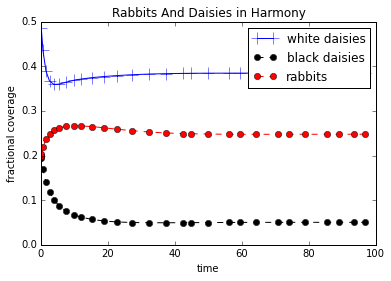

In [32]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


class Integ59(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbits])
        
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        beta_r = 0.69
        
        user = self.uservars
        
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi-(2)*(y[2] * (y[0]+y[1])) )
        f[1] = y[1] * (beta_b * bare - user.chi-(2)*(y[2] * (y[0]+y[1])))
        f[2] = y[2] * (beta_r * (y[0]+y[1]) - user.rabbit_chi)
        
        return f
    

theSolver = Integ59('adapt2.yaml')
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbit'])

thefig,theAx=plt.subplots(1,1)

points,=theAx.plot(timeVals,yvals['white'],'-b+',label='white daisies')
points.set_markersize(12)
theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='black daisies')
theLine2,=theAx.plot(timeVals,yvals['rabbit'],'--ro',label='rabbits')
theAx.set_title('Rabbits And Daisies in Harmony')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out=theAx.legend(loc='best')


3.  A discussion of the steady state’s dependence on these values, i.e.
    what happens when they are altered. Include a few plots for
    illustration.

From the steady-state that I found above, I changed both the rabbit death rate (Figs 1 and 2) and the initial proportion of rabbits. With a high death rate, in Fig 1, under this parametrization the rabbits die out. In Fig 2, with a lower death rate, they reach a higher steady state than before, but the black daisies die. In Figs 3 and 4, I simply change the initial proportion of rabbits, and they seem to approach the same steady state. 

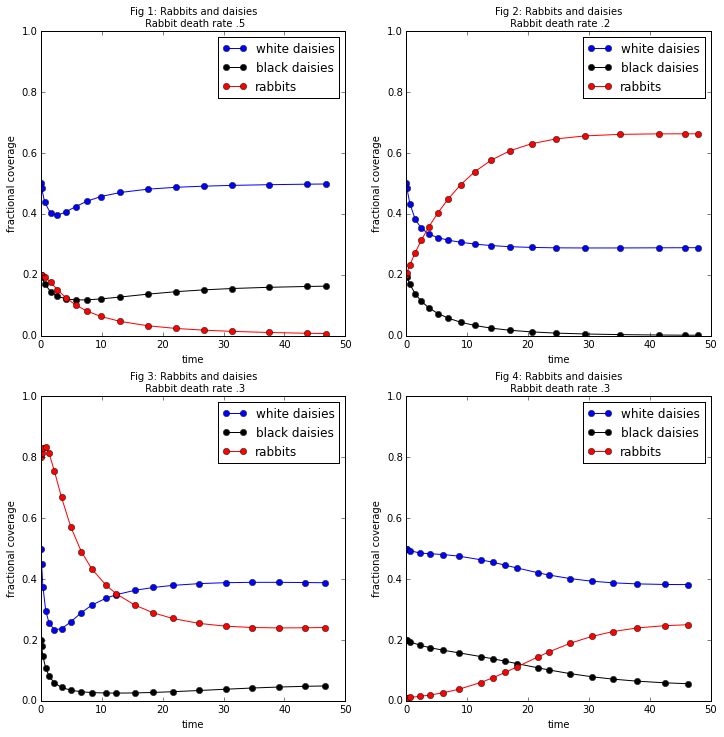

In [103]:
file_list = ['adapt3.yaml','adapt4.yaml','adapt5.yaml','adapt6.yaml']
str_list  = ['Fig 1','Fig 2','Fig 3','Fig 4']
death_list = ['.5','.2','.3','.3']

#print(file_list[0])


fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    theSolver = Integ59(file_list[i-1])
    timeVals,yVals,errorList=theSolver.timeloop5Err()
    
    theLines = ax.plot(timeVals, yVals)  
    theLines[0].set_marker('o')
    theLines[0].set_linestyle('-')
    theLines[1].set_color('k')
    theLines[1].set_marker('o')
    theLines[2].set_color('r')
    theLines[2].set_marker('o')

    ax.legend(theLines, ('white daisies', 'black daisies','rabbits'), loc='best')
    #ax.plot(timeVals[1], yVals[1])
    titl =  str_list[i-1]  + ": Rabbits and daisies\n Rabbit death rate " + death_list[i-1]
    ax.hold(True)
    ax.set_title(titl, fontsize = 10)
    ax.set_xlabel("time")
    ax.set_ylabel("fractional coverage")
    ax.set_ylim(0,1)
fig.set_facecolor('w')
plt.show()

4.  Does adding this feedback extend the range of habital L values  for which
    non-zero populations exist?  
    
    To answer this, I wrote an extra class, Integ59a, which is the same as Integ59 but with no rabbits. It appears that rabbit stress actually slightly decreases the range of available habital Ls - see the comparison of the two subplot sets (first without rabbits, second with an initial proportion of .1 rabbits). Here I defined non-zero steady state as "some flowers growing", but didn't require both black and white daisies to be nonzero - at the low end of L, the black daisies do well, at the high end, white ones do. To an accuracy of .01, we see:
    
    Without rabbits: L .72-1.36
    
    With rabbits: L .72-1.34
    
However, this is also dependent on the initial concentrations of daisies and rabbits - with an initial concentration of .9 rabbits and L = 1.34, everything dies- presumably because the daisies cannot withstand both light and rabbit stress. Everything is in a  delicate balance, and perturbations cause collapse - this is also why an atmospheric CO2 level of 398ppm is really scary.



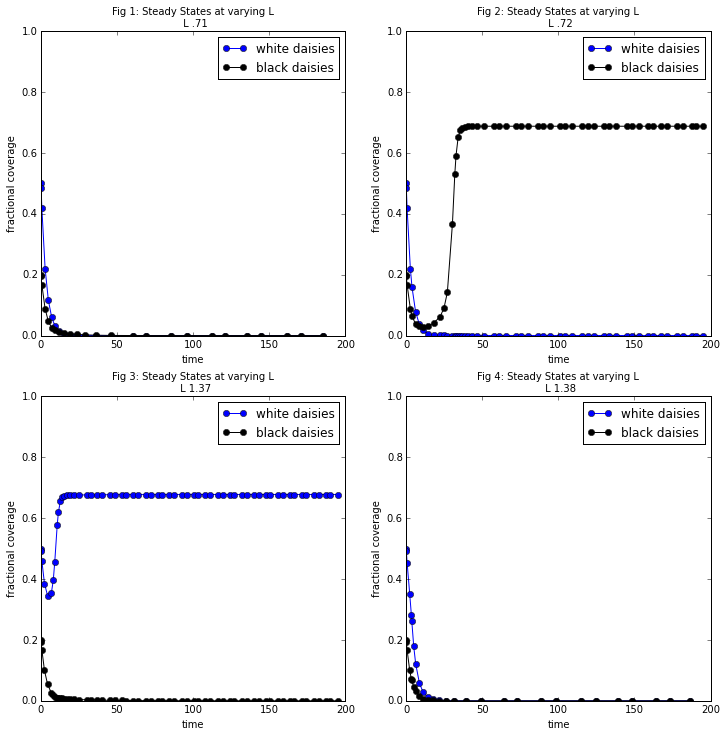

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


class Integ59a(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rabbits])
        
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):

        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        beta_r = 0.69
        
        user = self.uservars
        
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi )
        f[1] = y[1] * (beta_b * bare - user.chi)
        
        return f
    
file_list = ['adapt7.yaml','adapt8.yaml','adapt9.yaml','adapt10.yaml']
str_list  = ['Fig 1','Fig 2','Fig 3','Fig 4']
death_list = ['.71','.72','1.37','1.38']

fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    theSolver = Integ59a(file_list[i-1])
    timeVals,yVals,errorList=theSolver.timeloop5Err()
    
    theLines = ax.plot(timeVals, yVals)  
    theLines[0].set_marker('o')
    theLines[0].set_linestyle('-')
    theLines[1].set_color('k')
    theLines[1].set_marker('o')
    theLines[2].set_linestyle(' ')

    ax.legend(theLines, ('white daisies', 'black daisies'), loc='best')
    titl =  str_list[i-1]  + ": Steady States at varying L\n L " + death_list[i-1]
    ax.hold(True)
    ax.set_title(titl, fontsize = 10)
    ax.set_xlabel("time")
    ax.set_ylabel("fractional coverage")
    ax.set_ylim(0,1)
fig.set_facecolor('w')
plt.show()


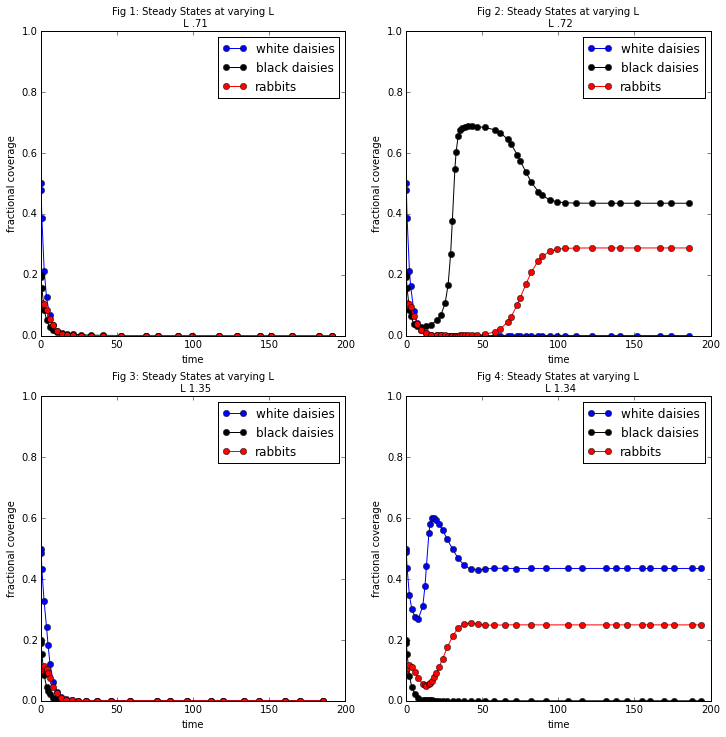

In [101]:
file_list = ['adapt7.yaml','adapt8.yaml','adapt11.yaml','adapt12.yaml']
str_list  = ['Fig 1','Fig 2','Fig 3','Fig 4']
death_list = ['.71','.72','1.35','1.34']

#print(file_list[0])


fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    theSolver = Integ59(file_list[i-1])
    timeVals,yVals,errorList=theSolver.timeloop5Err()
    
    theLines = ax.plot(timeVals, yVals)  
    theLines[0].set_marker('o')
    theLines[0].set_linestyle('-')
    theLines[1].set_color('k')
    theLines[1].set_marker('o')
    theLines[2].set_color('r')
    theLines[2].set_marker('o')

    ax.legend(theLines, ('white daisies', 'black daisies','rabbits'), loc='best')
    #ax.plot(timeVals[1], yVals[1])
    titl =  str_list[i-1]  + ": Steady States at varying L\n L " + death_list[i-1]
    ax.set_title(titl, fontsize = 10)
    ax.set_xlabel("time")
    ax.set_ylabel("fractional coverage")
    ax.set_ylim(0,1)
fig.set_facecolor('w')
plt.show()